# Startups operations/close predictions

### 1. Описание задачи

Работа над проектом происходидила в рамках соревнований на платформе Kaggle, c псевдо-реальными данными о стартапах, функционировавших в период с 1980 по 2018 годы. Необходимо было предсказать, какие из них закроются.

*Основные этапы исследования:*
 - загрузка и ознакомление с данными,
 - предварительная обработка,
 - полноценный разведочный анализ,
 - разработка новых синтетических признаков,
 - проверка на мультиколлинеарность,
 - отбор финального набора обучающих признаков,
 - выбор и обучение моделей,
 - итоговая оценка качества предсказания лучшей модели,
 - анализ важности ее признаков,
 - подготовка отчета по исследованию.

*Данные.*

Датасет состоит из двух файлов: 
- тренировочный набор __kaggle_startups_train_01.csv__ - информация (53 000) о  стартапах, которые будут использоваться в качестве обучающих данных;
- тестовый набор __kaggle_startups_test_01.csv__ - информация (13 000) о стартапах, которые будут использоваться в качестве тестовых данных, содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. 
  
Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

*Описание полей данных:*
- __name__ - название стартапа,
- __category_list__ - cписок категорий, к которым относится стартап,
- __funding_total_usd__- общая сумма финансирования в USD,
- __status__ - статус стартапа (закрыт или действующий),
- __country_code__ - код страны,
- __state_code__ - код штата,
- __region__ - регион,
- __city__ - город,
- __funding_rounds__ - количество раундов финансирования,
- __founded_at__ - дата основания,
- __first_funding_at__ - дата первого раунда финансирования,
- __last_funding_at__ - дата последнего раунда финансирования,
- __closed_at__ - дата закрытия стартапа (если применимо).

### 2. Загрузка и ознакомление с данными

In [1]:
# Импорт библиотек
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
import re
import phik
import shap

from wordcloud import WordCloud
from scipy import stats as st
from matplotlib import rcParams 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats as stats
from phik import resources, report

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ( 
    accuracy_score, 
    precision_score, 
    recall_score, 
    confusion_matrix,
    f1_score)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import ( 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    FunctionTransformer,
    RobustScaler,
    )
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

RANDOM_STATE = 42
TEST_SIZE = 0.25

# Размер шрифта для заголовка графиков
rcParams['axes.titlesize'] = 14
# Толщина линии по умолчанию
rcParams['lines.linewidth'] = 0.5
# Параметры для гистограммы
# Принудительное использование цвета края
rcParams['patch.force_edgecolor'] = True
rcParams['patch.edgecolor'] = 'white'
# Размер шрифта подписи оси X
rcParams['xtick.labelsize'] = 9 # Размер шрифта подписи оси Y rcParams['ytick.labelsize'] = 10

/Users/irina/GitHub/project-startups/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.1 Загрузим и рассмотрим тренировочную выборку

In [2]:
# Сохраним данные в переменную  startups_train
try:
    # Попытка загрузить данные с пути, специфичного для платформы (например, сервера, облака и т.д.)
    startups_train = pd.read_csv('./kaggle_startups_train_01.csv', 
                sep = ',', converters={'category_list': lambda x: x.replace('|', ', ')}, decimal='.')
except FileNotFoundError:
    # Попытка загрузить данные с локального пути, если первая попытка не удалась
    startups_train = pd.read_csv('./kaggle_startups_train_01.csv', 
                sep = ',', converters={'category_list': lambda x: x.replace('|', ', ')}, decimal='.')

In [3]:
# Выведем и рассмотрим данные 
startups_train.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,"Online Reservations, Restaurants",828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,NaN
1,EarLens,"Manufacturing, Medical, Medical Devices",42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN


В столбце state_code строковые и возможно не строковые значения, нужно проверить и привести к единому типу если понадобится.

Столбцы, которые можно использовать как входные признак:
- category_list - категориальный признак,
- funding_total_usd - количественный признак,
- country_code - категориальный признак,
- state_code - категориальный признак, если все данные строки,
- region -  категориальный признак,
- city - категориальный признак,
- funding_rounds - категориальный признак,
- founded_at и first_funding_at - преобразовать в новый количественный признак (количество дней с момента основания до первого этапа финансирования),
- founded_at и last_funding_at - преобразовать в новый количественный признак (количество дней с момента основания до последнего этапа финансирования).
Все признаки проверить на мультиколлинеарность и убрать в случае необходимости.

In [4]:
# Посмотрим типы данные и количество значений по столбцам
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52879 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52878 non-null  object 
 1   category_list      52879 non-null  object 
 2   funding_total_usd  42753 non-null  float64
 3   status             52879 non-null  object 
 4   country_code       47351 non-null  object 
 5   state_code         46082 non-null  object 
 6   region             46489 non-null  object 
 7   city               46489 non-null  object 
 8   funding_rounds     52879 non-null  int64  
 9   founded_at         52879 non-null  object 
 10  first_funding_at   52858 non-null  object 
 11  last_funding_at    52879 non-null  object 
 12  closed_at          4962 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


Тип данных столбцов __founded_at__ и __first_funding_at__, __last_funding_at__ можно привести к типу datetime, для того что-бы вычислить количество дней с момента основания стартапа до первого и последнего этапов финансирования. Возможно появится связь между продолжительностью этапов, финансиронием и целевым признаком.

In [5]:
# Проверка количества пропусков
startups_train.isna().sum()

name                     1
category_list            0
funding_total_usd    10126
status                   0
country_code          5528
state_code            6797
region                6390
city                  6390
funding_rounds           0
founded_at               0
first_funding_at        21
last_funding_at          0
closed_at            47917
dtype: int64

Основная проблема - это пропуски. Посмотрим каждый столбец и определим рекомендации для дальнейшей предобработке.

In [6]:
# Проверим дубликаты и выведем их сумму
startups_train.duplicated().sum()

0

Явных дубликатов нет.

2.1.1 Данные столбца __name__ - название стартапа.

В стобце есть один пропуск, выведем его. Тип данных корректный.

In [7]:
# Выведем пропуски
startups_train[startups_train['name'].isnull()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3321,NaN,Startups,25000.0,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-12-12


В строке 3321 значение NaN следует заменить на Unknown.

In [8]:
# Проверим уникальность имен
subscription_counts = startups_train['name'].value_counts()
subscription_counts

name
Lunchgate          1
Advanced Media     1
Cortex             1
Odysee             1
Camrivox           1
                  ..
Shhmooze           1
STREAMROOT         1
Insignia Health    1
Repair Report      1
Apparcando         1
Name: count, Length: 52878, dtype: int64

По видимому все имена стартапов уникальны.

2.1.2 Данные столбца __category_list__ - список категорий, к которым относится стартап.

In [9]:
# Посмотрим строки с пропусками
startups_train[startups_train['category_list'].isnull()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


Строкам с отсуствием категории свойственно отсуствие данных о финансировании, регионе, городе и т.д. Нужно режить имеют ли такие строки ценность для иследования. Пропуски можно заменить на unknown.

In [10]:
# Количество значений в категориях
count_of_values = startups_train['category_list'].value_counts()
count_of_values

category_list
Software                                                                                       3216
Biotechnology                                                                                  2917
                                                                                               2505
E-Commerce                                                                                     1067
Mobile                                                                                          921
                                                                                               ... 
Customer Service, Electrical Distribution, Services, Utilities                                    1
iPad, Reviews and Recommendations, Social Television, Software, Television, Video on Demand       1
Graphics, Software, Startups                                                                      1
Curated Web, File Sharing, Graphics, PaaS                                             

Количество категорий 22197

In [11]:
# Фильтруем, оставляя только категории с одним значением
single_count_of_values = count_of_values[count_of_values == 1]

# Выводим результат 
print(single_count_of_values.sum())

20215


Наибольшее количество стартапов относят себя к категории Software. Так же видно, что ряд стартапов относят себя к нескольким категориям, при этом набор категорий уникален для большого числа компаний. Общее количество категорий, встретившихся в датафрейме ровно один раз 20215. Можно было бы единичные категории отнести к более крупным, но это может испортить данные. Поэтому оставим как есть.

2.1.3 Данные столбца __funding_total_usd__ - общая сумма финансирования в USD.

In [12]:
# Приведем цифры в более читаемый формат
pd.set_option('display.float_format', '{:.0f}'.format)

# Посмотрим описательные характеристики признаков funding_total_usd и funding_rounds
startups_train['funding_total_usd'].describe()

count         42753
mean       18930591
std       205328790
min               1
25%          340000
50%         2000000
75%        10000000
max     30079503000
Name: funding_total_usd, dtype: float64

Как видно минимальное финансирование 1 USD, максимальное 30 079 503 000 USD, возможно это выброс, в процессе разведочного анализа можно будет установить точно.

In [13]:
# Проверка количества пропусков
startups_train['funding_total_usd'].isna().sum()

10126

Пропуски можно заменить 0 на этапе подготовки данных к обучению моделей.

2.1.4 Данные столбца __status__ - Статус стартапа (закрыт или действующий).

Целевой признак (бинарнымй) для тренировочной выборки и цель предсказаний лучшей модели для тестовой выборки.

2.1.5 Данные столбца __country_code__ - код страны.

In [14]:
# Определение маски для фильтрации строк с пропущенными значениями во всех указанных столбцах
mask = startups_train[['funding_total_usd', 'country_code', 'state_code', 'region', 'city']].isna().all(axis=1)

# Вывод строк с пропущенными значениями
print("Строки с пропущенными значениями во всех указанных столбцах:\n", startups_train.loc[mask])


Строки с пропущенными значениями во всех указанных столбцах:
                          name  \
16                   Salesjob   
24                    Savasti   
65         Seamless Logistics   
79           Efficient Photon   
156               Public Post   
...                       ...   
52757             Ogg Trading   
52767               Beach Bum   
52782              iSend, LLC   
52783       Deutsche Startups   
52792  OmniTrail Technologies   

                                           category_list  funding_total_usd  \
16                                                                      NaN   
24                                                                      NaN   
65                                                                      NaN   
79                                                                      NaN   
156                                                                     NaN   
...                                                  ...           

In [15]:
# Удаление строк, где одновременно нет данных в указанных столбцах

startups_train = startups_train.dropna(subset=['funding_total_usd', 'country_code', 'state_code', 'region', 'city'], how='all')

In [16]:
# Проверка количества пропусков
startups_train['country_code'].isna().sum()

3697

In [17]:
# Проверим возможно ли востановить country_code на основе данных state_code
filtered_state_code = startups_train[startups_train['country_code'].isna() & startups_train['state_code'].notna()]

filtered_state_code

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


К сожалению коды стран по кодам штатов восстановить не возможно. 

In [18]:
# Проверим возможно ли востановить country_code на основе данных region
filtered_region = startups_train[startups_train['country_code'].isna() & startups_train['region'].notna()]

filtered_region

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


К сожалению коды стран по регионам восстановить не возможно. 

In [19]:
# Проверим возможно ли востановить country_code на основе данных region
filtered_city = startups_train[startups_train['country_code'].isna() & startups_train['city'].notna()]

filtered_city

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


К сожалению коды стран по городам восстановить не возможно. Пропуски в этом столбце можно заменить на unknown или удалить строки в которых отсуствуют данные о финансировании, городе, регионе, коде страны и штата одновременно.

In [20]:
percent_nan = startups_train['country_code'].isna().mean() * 100
print(f"Процент значений NaN в столбце 'country_code': {percent_nan:.0f}%")

Процент значений NaN в столбце 'country_code': 7%


2.1.6 Данные столбца __state_code__ - код штата.

Определим количество значений в столбце state_code, которые могут требовать дополнительной обработки или исправления, поскольку они не соответствуют ожидаемому типу данных (строкам), но при этом не являются пустыми (NaN).

In [21]:
# Определение Нестроковых и Ненулевых значений
not_string_values = startups_train['state_code'].apply(lambda x: not isinstance(x, str) and pd.notna(x))
# Подсчет количества Нестроковых и Ненулевых значений
num_not_string_values = not_string_values.sum()
num_not_string_values

0

Таких значений в столбце state_code не оказалось, значит тип данных оставим как есть.

In [22]:
percent_nan = startups_train['state_code'].isna().mean() * 100
print(f"Процент значений NaN в столбце 'state_code': {percent_nan:.0f}%")

Процент значений NaN в столбце 'state_code': 10%


2.1.7 Данные столбца __region__ - регион.

Определим количество значений в столбце region, которые являются пустыми (NaN).

In [23]:
percent_nan = startups_train['region'].isna().mean() * 100
print(f"Процент значений NaN в столбце 'region': {percent_nan:.0f}%")

Процент значений NaN в столбце 'region': 9%


2.1.8 Данные столбца __city__ - город.

Определим количество значений в столбце город, которые являются пустыми (NaN).

In [24]:
percent_nan = startups_train['city'].isna().mean() * 100
print(f"Процент значений NaN в столбце 'city': {percent_nan:.0f}%")

Процент значений NaN в столбце 'city': 9%


2.1.9 Данные столбца __funding_rounds__ - количество раундов финансирования.

Пропусков в этом столбце ранее не было обнаруженно. Посмотрим количество раундов.

In [25]:
# Количество категорий
startups_train['funding_rounds'].unique()


array([ 2,  4,  3,  1,  5,  7,  9,  6,  8, 10, 11, 12, 15, 13, 16, 17, 14,
       18, 19])

В целом райндов финансирования у стартапов было от 1 до 19.

2.1.10 Данные столбца __founded_at__ - дата основания.

Пропусков в этом столбце ранее не обнаруженно. Тип данных необходимо привести к типу datetime, для того что-бы можно было бы использовать этот их для создания нового признака.

In [26]:
# Преобразование столбца founded_at с датами из строки в datetime
startups_train['founded_at_date'] = pd.to_datetime(startups_train['founded_at'])
# Удалим столбец founded_at
del startups_train['founded_at']
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51048 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               51047 non-null  object        
 1   category_list      51048 non-null  object        
 2   funding_total_usd  42753 non-null  float64       
 3   status             51048 non-null  object        
 4   country_code       47351 non-null  object        
 5   state_code         46082 non-null  object        
 6   region             46489 non-null  object        
 7   city               46489 non-null  object        
 8   funding_rounds     51048 non-null  int64         
 9   first_funding_at   51028 non-null  object        
 10  last_funding_at    51048 non-null  object        
 11  closed_at          4530 non-null   object        
 12  founded_at_date    51048 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(10)
memory usag

Столбец founded_at_date теперь содержит значения столбца founded_at нужного типа. Столбец founded_at удален.

2.1.11 Данные столбца __first_funding_at__ - дата первого раунда финансирования.

Пропуски в столбце при создании нового признака дадут значение NaN. Тип данных необходимо привести к типу datetime, для того что-бы можно было бы использовать их для создания нового признака, который покажет сколько дней прошло с момента основания до первого раунда финансирования.

In [27]:
# Преобразование столбца first_funding_at_date с датами из строки в datetime
startups_train['first_funding_at_date'] = pd.to_datetime(startups_train['first_funding_at'])
# Удалим столбец first_funding_at
del startups_train['first_funding_at']
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51048 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   51047 non-null  object        
 1   category_list          51048 non-null  object        
 2   funding_total_usd      42753 non-null  float64       
 3   status                 51048 non-null  object        
 4   country_code           47351 non-null  object        
 5   state_code             46082 non-null  object        
 6   region                 46489 non-null  object        
 7   city                   46489 non-null  object        
 8   funding_rounds         51048 non-null  int64         
 9   last_funding_at        51048 non-null  object        
 10  closed_at              4530 non-null   object        
 11  founded_at_date        51048 non-null  datetime64[ns]
 12  first_funding_at_date  51028 non-null  datetime64[ns]
dtypes: dat

2.1.12 Данные столбца __last_funding_at__ - дата последнего раунда финансирования.

Пропусков в этом столбце ранее не обнаруженно. Тип данных необходимо привести к типу datetime, для того что-бы можно было бы использовать их для создания нового признака, который покажет сколько дней прошло с момента основания до последнего раунда финансирования.

In [28]:
# Преобразование столбца last_funding_at с датами из строки в datetime
startups_train['last_funding_at_date'] = pd.to_datetime(startups_train['last_funding_at'])
# Удалим столбец last_funding_at
del startups_train['last_funding_at']
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51048 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   51047 non-null  object        
 1   category_list          51048 non-null  object        
 2   funding_total_usd      42753 non-null  float64       
 3   status                 51048 non-null  object        
 4   country_code           47351 non-null  object        
 5   state_code             46082 non-null  object        
 6   region                 46489 non-null  object        
 7   city                   46489 non-null  object        
 8   funding_rounds         51048 non-null  int64         
 9   closed_at              4530 non-null   object        
 10  founded_at_date        51048 non-null  datetime64[ns]
 11  first_funding_at_date  51028 non-null  datetime64[ns]
 12  last_funding_at_date   51048 non-null  datetime64[ns]
dtypes: dat

2.1.13 Данные столбца __closed_at__ - дата закрытия стартапа.

Пропуски можно заполнить датой формирования выгрузки - '2018-01-01' и затем преобразовать в тип datetime, что бы создать новый признак, который покажет количество дней с момента основания стартапа до закрытия и с момента основания по 1 января 2018.

In [29]:
# Преобразуем столбец
startups_train['closed_at_date'] = pd.to_datetime(startups_train['closed_at'])
# Заполняем пропуски
startups_train['closed_at_date'].fillna(pd.Timestamp('2018-01-01'), inplace=True)
# Удалим столбец closed_at
del startups_train['closed_at']

startups_train.info()
startups_train.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 51048 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   51047 non-null  object        
 1   category_list          51048 non-null  object        
 2   funding_total_usd      42753 non-null  float64       
 3   status                 51048 non-null  object        
 4   country_code           47351 non-null  object        
 5   state_code             46082 non-null  object        
 6   region                 46489 non-null  object        
 7   city                   46489 non-null  object        
 8   funding_rounds         51048 non-null  int64         
 9   founded_at_date        51048 non-null  datetime64[ns]
 10  first_funding_at_date  51028 non-null  datetime64[ns]
 11  last_funding_at_date   51048 non-null  datetime64[ns]
 12  closed_at_date         51048 non-null  datetime64[ns]
dtypes: dat

/var/folders/g4/3vg7s0hj61z1d8hwbk8s10rh0000gn/T/ipykernel_23151/2082324714.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  startups_train['closed_at_date'].fillna(pd.Timestamp('2018-01-01'), inplace=True)


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at_date,first_funding_at_date,last_funding_at_date,closed_at_date
0,Lunchgate,"Online Reservations, Restaurants",828626,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,2018-01-01
1,EarLens,"Manufacturing, Medical, Medical Devices",42935019,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01
2,Reviva Pharmaceuticals,Biotechnology,35456381,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01
3,Sancilio and Company,Health Care,22250000,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,2018-01-01


Тип данных успешно заменён, пропуски заполнены датой выгрузки.

Общие рекомендации к предобработке данных:
- name - в стобце есть один пропуск, заменим его на unknown, тип данных корректный;
- category_list 
  -  строкам с отсуствием категории свойственно отсуствие данных о финансировании, регионе, городе и т.д., нужно решить имеют ли такие строки ценность для иследования, 
  -  пропуски можно заменить на unknown, 
  -  наибольшее количество стартапов относят себя к категории Software, 
  -  ряд стартапов относят себя к нескольким категориям, 
  -  набор категорий уникален для большого числа компаний, 
  -  общее количество категорий, встретившихся в датафрейме ровно один раз 20215,
- funding_total_usd 
  - минимальное финансирование 1 USD, максимальное 30 079 503 000 USD, возможно это выброс, в процессе разведочного анализа можно будет установить точно.
  - пропуски можно заменить на 0;
- status - целевой признак (бинарнымй) для тренировочной выборки и цель предсказаний лучшей модели для тестовой выборки;
- country_code - к сожалению коды стран по городам восстановить не возможно,
 - пропуски в этом столбце можно заменить на unknown или удалить строки в которых отсуствуют данные о финансировании, городе, регионе, коде страны и штата одновременно,
 - процент значений NaN в столбце 'country_code': 10%;
- state_code - коды штатов по городам восстановить не возможно,
 - пропуски в этом столбце можно заменить на unknown или удалить строки в которых отсуствуют данные о финансировании, городе, регионе, коде страны и штата одновременно,
 - процент значений NaN в столбце 'state_code': 13%;
- region - регионы по городам восстановить не возможно. Пропуски в этом столбце можно заменить на unknown или удалить строки в которых отсуствуют данные о финансировании, городе, регионе, коде страны и штата одновременно;
- city - процент значений NaN в столбце 'city': 12%;
- funding_rounds - в целом раундов финансирования у стартапов было от 1 до 19, пропусков нет;
- founded_at - пропусков в этом столбце ранее не обнаруженно, тип данных приведён к типу datetime, для того что-бы можно было бы использовать этот их для создания нового признаков;
- first_funding_at - тип данных приведён к типу datetime, для того что-бы можно было бы использовать их для создания нового признака, который покажет сколько дней прошло с момента основания до первого раунда финансирования;
- last_funding_at - тип данных приведён к типу datetime, для того что-бы можно было бы использовать их для создания нового признака, который покажет сколько дней прошло с момента основания до первого раунда финансирования;
- closed_at - тип данных успешно заменён, пропуски заполнены датой выгрузки, это позволит создать новый признак, который покажет сколько дней прошло с момента основания до закрытия или до даты выгрузки.

2.2 Загрузим и рассмотрим тестовую выборку

In [30]:
# Сохраним данные в переменную  startups_test
try:
    # Попытка загрузить данные с пути, специфичного для платформы (например, сервера, облака и т.д.)
    startups_test = pd.read_csv('./kaggle_startups_test_01.csv', 
    sep=',',
    converters={'category_list': lambda x: x.replace('|', ', ')}, decimal='.')
    
except FileNotFoundError:
    # Попытка загрузить данные с локального пути, если первая попытка не удалась
    startups_test = pd.read_csv('./kaggle_startups_test_01.csv', 
    sep=',',
    converters={'category_list': lambda x: x.replace('|', ', ')}, decimal='.')
    

Тестовая выборка успешно загруженна. Рассмотрим её.

In [31]:
# Проверим дубликаты и выведем их сумму
startups_test.duplicated().sum()

0

In [32]:
startups_test.shape

(13211, 12)

Явных дубликатов нет.

In [33]:
startups_test.head(2)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Crystalsol,Clean Technology,2819200,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,NaN
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,NaN


Тестовая выборка содержит такие же столбцы, что и тренировочная, значит с созданием новых признаков, аналогичных тренировочным, проблем не должно возникнуть.

In [34]:
# Проверим совпадают названия стартапов в тренировочной и тестовой выборках
names_in_both = startups_test['name'].isin(startups_train['name'])

# Выводим значения, которые совпадают
print(startups_test['name'][names_in_both])

Series([], Name: name, dtype: object)


Тестовая выборка содержит аналогичную информацию о стартапах, но это другие стартапы.

In [35]:
# Количество категорий
subscription_counts = startups_test['category_list'].value_counts()
subscription_counts

category_list
Software                                                                      775
Biotechnology                                                                 696
                                                                              601
E-Commerce                                                                    264
Mobile                                                                        255
                                                                             ... 
Customer Service, Software, Technology                                          1
Entertainment, Games, Music, Startups, Video                                    1
E-Commerce, Games, Gift Card, Monetization, Payments                            1
Advertising, Video, Video Streaming                                             1
Communications Hardware, Messaging, Mobile, Office Space, Technology, VoIP      1
Name: count, Length: 6221, dtype: int64

Так же как и тренировочная выборка содержит схожие категории стартапов.

In [36]:
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13211 entries, 0 to 13210
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13211 non-null  object 
 1   category_list      13211 non-null  object 
 2   funding_total_usd  10616 non-null  float64
 3   country_code       11827 non-null  object 
 4   state_code         11512 non-null  object 
 5   region             11618 non-null  object 
 6   city               11620 non-null  object 
 7   funding_rounds     13211 non-null  int64  
 8   founded_at         13211 non-null  object 
 9   first_funding_at   13211 non-null  object 
 10  last_funding_at    13211 non-null  object 
 11  closed_at          1234 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 1.2+ MB


Есть пропуски в ряде столбцов, как и в тренировочной выборке. Типы данных для столбцов с датами, необходимо привести к нужному типу. Все манипуляции с данными тестовой выборки рекомендуется сделать, после разведочного анализа тренировочной выборки и после выявления лучшей модели для предсказания, непосредственно перед передачей данных тестовой выборки в лучшую модель с целью предсказания целевого признака.

### 3. Предварительная обработка тренировочной выборки

Оставим данные из временного периода - '1970-01-01' по '2018-01-01'.

In [37]:
# Определение начальной и конечной даты временного периода
start_date = pd.to_datetime('1970-01-01')
end_date = pd.to_datetime('2018-01-01')

# Фильтрация DataFrame, чтобы оставить только строки, подходящие под временной период
startups_train = startups_train[(startups_train['founded_at_date'] >= start_date) & (startups_train['founded_at_date'] <= end_date)]
startups_train.shape

(50748, 13)

Проведем работу с пропусками.

In [38]:
# Проверка количества пропусков
startups_train.isna().sum()

name                        1
category_list               0
funding_total_usd        8252
status                      0
country_code             3685
state_code               4949
region                   4543
city                     4543
funding_rounds              0
founded_at_date             0
first_funding_at_date      20
last_funding_at_date        0
closed_at_date              0
dtype: int64

In [39]:
# Выведем пропуски
startups_train[startups_train['name'].isnull()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at_date,first_funding_at_date,last_funding_at_date,closed_at_date
3321,NaN,Startups,25000,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-12-12


In [40]:
# Заменяем np.nan на 'unknown'
startups_train['name'] = startups_train['name'].fillna('unknown')
startups_train.loc[3321]

name                                 unknown
category_list                       Startups
funding_total_usd                      25000
status                                closed
country_code                             USA
state_code                                OR
region                      Portland, Oregon
city                                Portland
funding_rounds                             1
founded_at_date          2011-10-01 00:00:00
first_funding_at_date    2012-03-01 00:00:00
last_funding_at_date     2012-03-01 00:00:00
closed_at_date           2013-12-12 00:00:00
Name: 3321, dtype: object

Теперь пропуск заменён значением unknown.

In [41]:
startups_train['funding_total_usd'].fillna(0.0, inplace=True)
# Преобразование столбца funding_total_usd из float в int64
startups_train['funding_total_usd'] = startups_train['funding_total_usd'].astype('int64')

/var/folders/g4/3vg7s0hj61z1d8hwbk8s10rh0000gn/T/ipykernel_23151/1177289864.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  startups_train['funding_total_usd'].fillna(0.0, inplace=True)


In [42]:
columns_to_replace = ['country_code', 'state_code', 'region', 'city']  # Список столбцов для замены

# Замена значений NaN на 'unknown' в указанных столбцах
startups_train[columns_to_replace] = startups_train[columns_to_replace].fillna('unknown')


In [43]:
# Проверка количества пропусков
startups_train.isna().sum()

name                      0
category_list             0
funding_total_usd         0
status                    0
country_code              0
state_code                0
region                    0
city                      0
funding_rounds            0
founded_at_date           0
first_funding_at_date    20
last_funding_at_date      0
closed_at_date            0
dtype: int64

In [44]:
startups_train.shape

(50748, 13)

Разделим строки с мультикатегорией на отдельные строки с одной категорией.

In [45]:
# Преобразование строки в список категорий
startups_train['category_list'] = startups_train['category_list'].str.split(', ')
startups_train.head(5)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at_date,first_funding_at_date,last_funding_at_date,closed_at_date
0,Lunchgate,"[Online Reservations, Restaurants]",828626,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,2018-01-01
1,EarLens,"[Manufacturing, Medical, Medical Devices]",42935019,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01
2,Reviva Pharmaceuticals,[Biotechnology],35456381,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01
3,Sancilio and Company,[Health Care],22250000,operating,unknown,unknown,unknown,unknown,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01
4,WireTough Cylinders,[Manufacturing],0,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,2018-01-01


In [46]:
# Находим индекс строки с максимальной длиной
#idx_max_length = startups_train['category_list'].str.len().idxmax()

# Выведем всю строку с максимальной длиной в столбце 'description'
##longest_row = startups_train.loc[idx_max_length]

#print(longest_row)

In [47]:
# Разделяем столбец 'category_list' на несколько столбцов и присваиваем новые столбцы DataFrame
#startups_train[['category_1', 'category_2', 'category_3', 'category_4']] = startups_train['category_list'].str.split(', ', expand=True)
# Разделение с expand=True, что приводит к DataFrame
#split_df = startups_train['category_list'].str.split(', ', expand=True)

# Заполнение NaN, если таковые есть
#split_df = split_df.fillna('Unknown')

# Объединение с исходным DataFrame
#startups_train[['category_1', 'category_2', 'category_3', 'category_4']] = split_df

In [48]:
# Применение explode для преобразования каждого элемента списка в отдельную строку
train_exploded = startups_train.explode('category_list')
train_exploded.shape

(120679, 13)

Получили дополнительыне строчки.

In [49]:
# Проверим дубликаты и выведем их сумму
train_exploded.duplicated().sum()

0

Проверим перекрытие дат, дата основания стартапа должна быть самой ранней по сравнению с датой первого раунда финансирования, последнего раунда финансирования и закрытием.

In [50]:
# Фильтруем строки, где даты закрытия, первого и последнего раундов финансирования позже даты основания
train_filtered_date = train_exploded[(train_exploded['first_funding_at_date'] > train_exploded['founded_at_date'])|
                        (train_exploded['last_funding_at_date'] > train_exploded['founded_at_date']) |
                        (train_exploded['closed_at_date'] > train_exploded['founded_at_date'])
                        ]
num_rows_filtered = len(train_filtered_date)
train_filtered_date.reset_index(drop=True, inplace=True)

print(f"Количество отфильтрованных строк: {num_rows_filtered}")
#train_filtered_date.head(3)

Количество отфильтрованных строк: 120616


Для дальнейшей работы будем использовать отфильтрованый датафрейм, где дата основания раньше дат раундов, закрытия, выгрузки данных.

### 4. Разведочный анализ

После предподготовки тренировочной выборки можем провести разведочный анализ. Посмотрим распределение значений сепарируя их по статусу закрыт или действующий (closed/operating), для того что-бы выявить особенности этих групп.

4.1 Разделем тренеровочную выборку на две группы - закрытые и действующие стартапы.

Закрытые стартапы.

In [51]:
# Фильтруем DataFrame, оставляя только те строки, где status == 'closed'
closed_df = train_filtered_date[train_filtered_date['status'] == 'closed']
closed_df.sample(2)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at_date,first_funding_at_date,last_funding_at_date,closed_at_date
64353,Zipano,Security,25000,closed,USA,PA,Pittsburgh,Pittsburgh,1,2009-06-01,2009-07-01,2009-07-01,2010-08-21
81636,muv today technologies inc,Transportation,7300,closed,MEX,9,Mexico City,Mexico City,1,2015-01-02,2015-03-25,2015-03-25,2016-11-18


Действующие стартапы.

In [52]:
# Фильтруем DataFrame, оставляя только те строки, где status == 'operating'
operating_df = train_filtered_date[train_filtered_date['status'] == 'operating']
operating_df.sample(2)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at_date,first_funding_at_date,last_funding_at_date,closed_at_date
19994,Infracommerce,E-Commerce,5983000,operating,BRA,2,Sao Paulo,São Paulo,4,2012-10-10,2012-10-15,2014-05-09,2018-01-01
37527,Myagi,Sales Automation,969533,operating,AUS,2,Melbourne,Abbotsford,2,2013-09-01,2014-06-20,2014-07-24,2018-01-01


Категориальные признаки.

4.1.1 Категории стартапов по группам.

Закрытые стартапы.

Для категориальных данных, где категории являются словами или фразами, облако слов визуализирует частоту встречаемости категорий, делая более крупными наиболее частые категории.

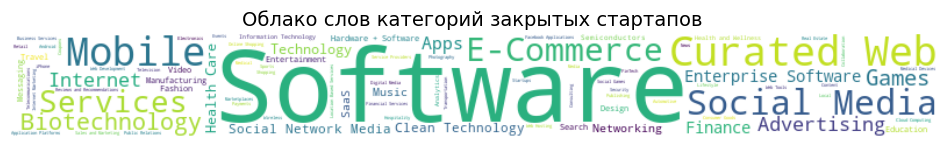

In [53]:
# Визуализация
wordcloud = WordCloud(width=800, height=90, background_color ='white').generate_from_frequencies(closed_df['category_list'].value_counts())

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
# Название графика
plt.title('Облако слов категорий закрытых стартапов ', fontsize=14)
plt.axis('off')
plt.show()

In [54]:
# Количество значений в категориях
count_of_values = closed_df['category_list'].value_counts()
count_of_values

category_list
Software              521
                      420
Curated Web           399
Mobile                381
Social Media          283
                     ... 
Parking                 1
Contact Centers         1
Smart Building          1
Remediation             1
Corporate Training      1
Name: count, Length: 654, dtype: int64

Самые наиболее распространённые категории - Software (521), категория не указана (420), Curated Web(399), Mobile (381), Social Media (283).

Действующие стартапы.

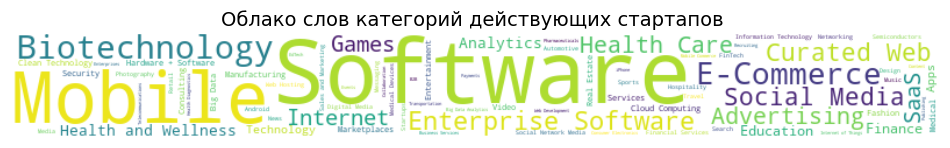

In [55]:
# Визуализация
wordcloud = WordCloud(width=800, height=90, background_color ='white').generate_from_frequencies(operating_df['category_list'].value_counts())

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
# Название графика
plt.title('Облако слов категорий действующих стартапов ', fontsize=14)
plt.axis('off')
plt.show()

In [56]:
# Количество значений в категориях
count_of_values = operating_df['category_list'].value_counts()
count_of_values

category_list
Software               6408
Mobile                 3931
Biotechnology          3442
E-Commerce             2978
Enterprise Software    2060
                       ... 
EDA Tools                 1
Low Bid Auctions          1
Early Stage IT            1
Timeshares                1
Racing                    1
Name: count, Length: 852, dtype: int64

Самые наиболее распространённые категории - Software (6408), Mobile (3931), Biotechnology (3442), E-Commerce (2978), , Enterprise Software (2060).

Сопадение по категориям - Software, Mobile, отличия в категориях - категория не указана, Curated Web,  Social Media.

4.1.2 Страны стартапов.

Закрытые стартапы.

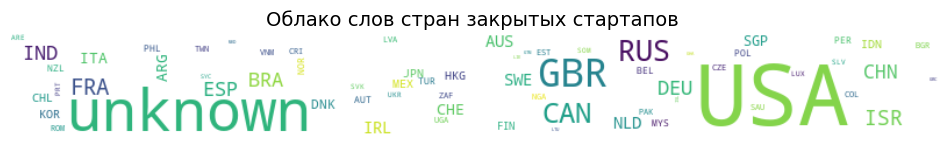

In [57]:
# Визуализация
wordcloud = WordCloud(width=800, height=90, background_color ='white').generate_from_frequencies(closed_df['country_code'].value_counts())

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
# Название графика
plt.title('Облако слов стран закрытых стартапов ', fontsize=14)
plt.axis('off')
plt.show()

In [58]:
# Количество значений в категориях
count_of_values = closed_df['country_code'].value_counts()
count_of_values

country_code
USA        5037
unknown    1911
GBR         581
RUS         292
CAN         278
           ... 
BLR           1
BLM           1
MLT           1
PRI           1
GEO           1
Name: count, Length: 76, dtype: int64

Наибольшее число стартапов было закрыто в США (5037), затем по убыванию - неизвестная страна (1911), Великобритания (581), Россия (292), Канада (278). 

Действующие стартапы.

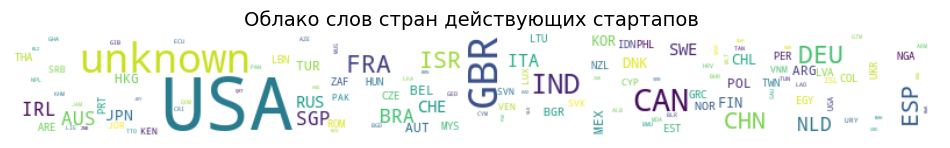

In [59]:
# Визуализация
wordcloud = WordCloud(width=800, height=90, background_color ='white').generate_from_frequencies(operating_df['country_code'].value_counts())

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
# Название графика
plt.title('Облако слов стран действующих стартапов ', fontsize=14)
plt.axis('off')
plt.show()

In [60]:
# Количество значений в категориях
count_of_values = operating_df['country_code'].value_counts()
count_of_values

country_code
USA        64208
unknown     6870
GBR         6717
CAN         3481
IND         2613
           ...  
TGO            1
KNA            1
GGY            1
IRN            1
MKD            1
Name: count, Length: 132, dtype: int64

Наибольшее число стартапов действует в США (64208), затем по убыванию - неизвестная страна (6870), Великобритания (6717), Канада (3481), Индия (2613). 

Совпадения по странам -  США, неизвестная страна, Великобритания,  Канада, различия Россия и Индия.

4.1.3 Штаты стартапов.

Закрытые стартапы

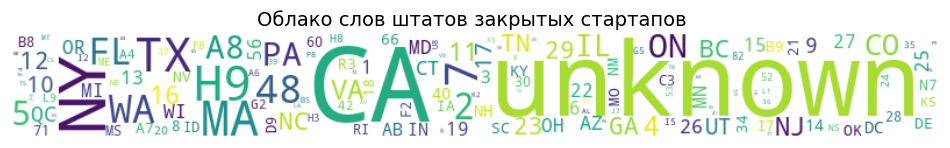

In [61]:
# Визуализация
wordcloud = WordCloud(width=800, height=90, background_color ='white').generate_from_frequencies(closed_df['state_code'].value_counts())

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
# Название графика
plt.title('Облако слов штатов закрытых стартапов ', fontsize=14)
plt.axis('off')
plt.show()

In [62]:
# Количество значений в категориях
count_of_values = closed_df['state_code'].value_counts()
count_of_values

state_code
CA         2183
unknown    2162
NY          600
H9          309
MA          303
           ... 
C1            1
32            1
E6            1
Q3            1
D5            1
Name: count, Length: 187, dtype: int64

Наибольшее число стартапов было закрыто в Калифорнии (2183), с неуказанном штате (2162), Нью-Йорк (600), H9(309), Массачу́сетс (303).

Действующие стартапы.

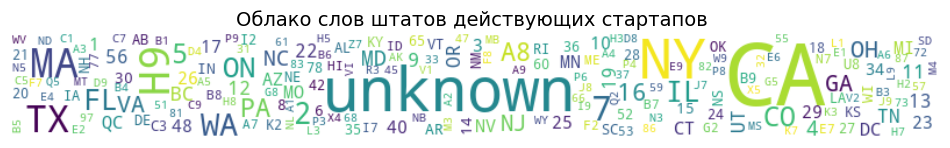

In [63]:
# Визуализация
wordcloud = WordCloud(width=800, height=90, background_color ='white').generate_from_frequencies(operating_df['state_code'].value_counts())

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
# Название графика
plt.title('Облако слов штатов действующих стартапов ', fontsize=14)
plt.axis('off')
plt.show()

In [64]:
# Количество значений в категориях
count_of_values = operating_df['state_code'].value_counts()
count_of_values

state_code
CA         23835
unknown     9619
NY          8193
H9          4104
MA          3894
           ...  
PE             1
39             1
43             1
89             1
U6             1
Name: count, Length: 300, dtype: int64

Наибольшее число стартапов действует в штате Калифорния (23835), неизвестный штат (9619), Нью-Йорк (8193), H9(4104), Массачу́сетс (3894).

Различий по штатам, не обнаруженно.

4.1.4 Регионы стартапов.

Закрытые стартапы.

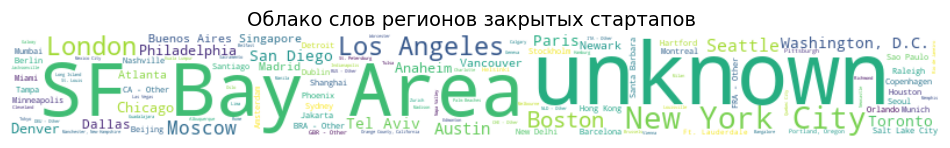

In [65]:
# Визуализация
wordcloud = WordCloud(width=800, height=90, background_color ='white').generate_from_frequencies(closed_df['region'].value_counts())

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
# Название графика
plt.title('Облако слов регионов закрытых стартапов ', fontsize=14)
plt.axis('off')
plt.show()

In [66]:
# Количество значений в категориях
count_of_values = closed_df['region'].value_counts()
count_of_values

region
unknown                  2077
SF Bay Area              1469
New York City             557
Los Angeles               365
London                    355
                         ... 
Florida's Space Coast       1
Columbus, Georgia           1
Corpus Christi              1
TN - Other                  1
Doncaster                   1
Name: count, Length: 441, dtype: int64

Наибольшее число стартапов было закрыто в не указанном регионе (2077), затем по убыванию - SF Bay Area (1469), Нью-Йорк (557), Лос Анджелес (365), Лондон (355).

Действующие стартапы.

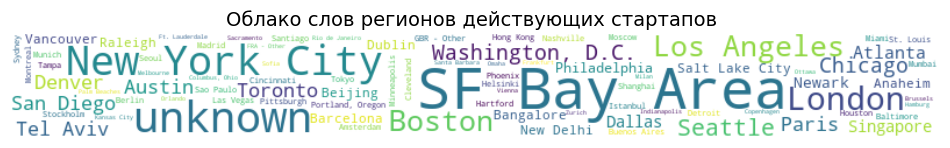

In [67]:
# Визуализация
wordcloud = WordCloud(width=800, height=90, background_color ='white').generate_from_frequencies(operating_df['region'].value_counts())

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
# Название графика
plt.title('Облако слов регионов действующих стартапов ', fontsize=14)
plt.axis('off')
plt.show()

In [68]:
# Количество значений в категориях
count_of_values = operating_df['region'].value_counts()
count_of_values

region
SF Bay Area       16804
unknown            8364
New York City      7593
London             4693
Los Angeles        3716
                  ...  
Yokohama              1
Cwmbran               1
Ghaziabad             1
Vijayawada            1
Haywards Heath        1
Name: count, Length: 1018, dtype: int64

Наибольшее число стартапов действует в регионе SF Bay Area (16804), неизвестный регион (8364), Нью-Йорк (7593), Лондон (4693), Лос Анджелес (3716).

Различий по регионам нет.

4.1.5 Города стартапов.

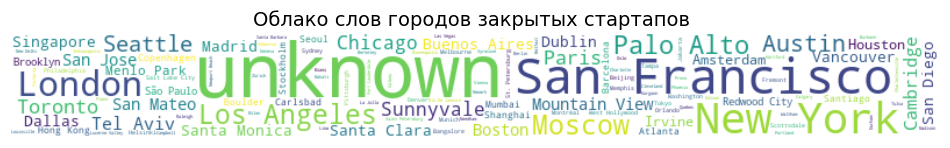

In [69]:
# Визуализация
wordcloud = WordCloud(width=800, height=90, background_color ='white').generate_from_frequencies(closed_df['city'].value_counts())

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
# Название графика
plt.title('Облако слов городов закрытых стартапов ', fontsize=14)
plt.axis('off')
plt.show()

In [70]:
# Количество значений в категориях
count_of_values = closed_df['city'].value_counts()
count_of_values

city
unknown           2077
San Francisco      650
New York           507
London             313
Los Angeles        190
                  ... 
Cáceres              1
Furtwangen           1
Port St. Lucie       1
Maple Valley         1
Doncaster            1
Name: count, Length: 980, dtype: int64

У значительной части закрытых стартапов нет информации о городе (2077), далее по убыванию - Сан-Франциско(650), Нью-Йорк (507), Лондон (313), Лос-Анджелес (190).

Действующие стартапы.

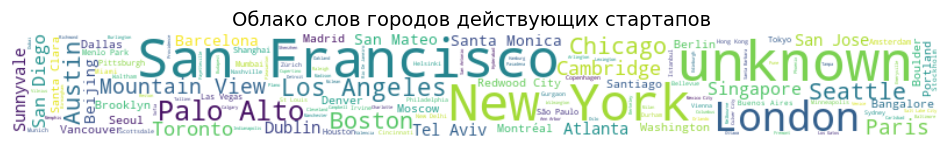

In [71]:
# Визуализация
wordcloud = WordCloud(width=800, height=90, background_color ='white').generate_from_frequencies(operating_df['city'].value_counts())

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
# Название графика
plt.title('Облако слов городов действующих стартапов ', fontsize=14)
plt.axis('off')
plt.show()

In [72]:
# Количество значений в категориях
count_of_values = operating_df['city'].value_counts()
count_of_values

city
unknown          8364
San Francisco    7611
New York         6861
London           4119
Palo Alto        1556
                 ... 
Barendrecht         1
Takapuna            1
Mcallen             1
Lilburn             1
Centreville         1
Name: count, Length: 4325, dtype: int64

У значительной части действующих стартапов нет информации о городе (8364), далее Сан-Франциско(7611), Нью-Йорк (6861), Лондон (4119), Поло-Альто (1556).

Совпадение - нет информации о городе, Сан-Франциско, Нью-Йорк, Лондон, различия Лос-Анджелес и Поло-Альто.

4.1.6 Количество раундов финансирования стартапов.

Закрытые стартапы.

In [73]:
# Количество раундов
subscription_counts = closed_df['funding_rounds'].value_counts()
subscription_counts

funding_rounds
1     7585
2     1712
3      521
4      206
5       89
6       43
8       24
7       16
9        8
11       3
10       1
Name: count, dtype: int64

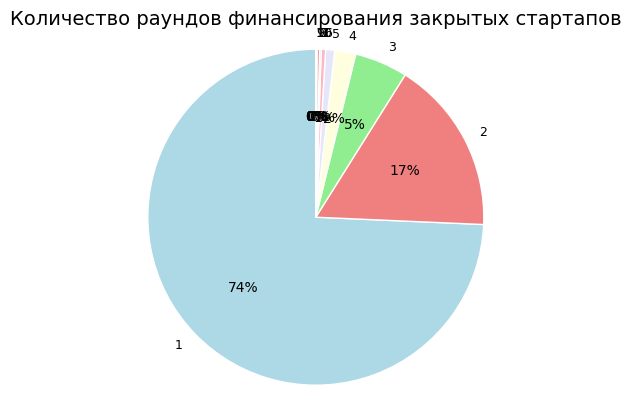

In [74]:
# Визуализация
labels = ['1', '2', '3', '4', '5','6', '7', '8', '9', '10', '11']
sizes = [subscription_counts[1],
        subscription_counts[2],subscription_counts[3],subscription_counts[4],
        subscription_counts[5], subscription_counts[6], subscription_counts[7],
        subscription_counts[8],subscription_counts[9],subscription_counts[10],
        subscription_counts[11]
        ]
colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow', 'lavender', 'lightpink',
          'lightblue', 'lightcoral', 'lightgreen', 'lightyellow', 'lavender', 
        ]

# График 
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%', shadow=False, startangle=90)
plt.axis('equal')
plt.title('Количество раундов финансирования закрытых стартапов')
plt.show()

Закрывшиеся стартапы прошли через десять раундов. Большая часть преодолела только 2 раунда. Как видно 74 % стартапов прошли только один раунд фанасирования и закрылись. 17 % прошли через два раунда и 5% прошли через три райунда финансирования.

Действующие стартапы.

In [75]:
# Количество раундов
subscription_counts = operating_df['funding_rounds'].value_counts()
subscription_counts

funding_rounds
1     63588
2     23058
3     11534
4      5614
5      3052
6      1663
7       877
8       384
9       244
10      126
11      120
12       73
13       22
16       21
15       14
14        7
17        5
18        5
19        1
Name: count, dtype: int64

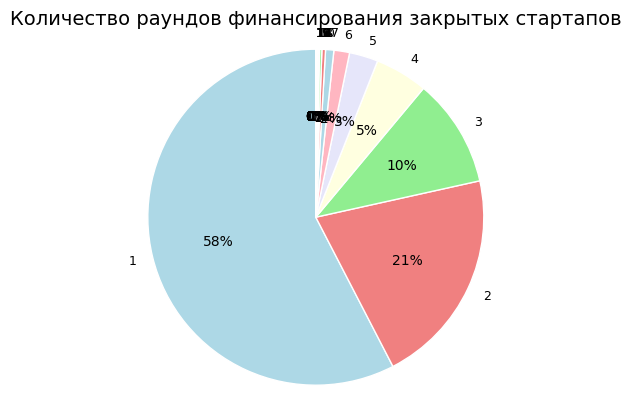

In [76]:
# Визуализация
labels = ['1', '2', '3', '4', '5','6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
sizes = [subscription_counts[1],
        subscription_counts[2],subscription_counts[3],subscription_counts[4],
        subscription_counts[5], subscription_counts[6], subscription_counts[7],
        subscription_counts[8],subscription_counts[9],subscription_counts[10],
        subscription_counts[11], subscription_counts[12],subscription_counts[13],
        subscription_counts[14], subscription_counts[15],subscription_counts[16],
        subscription_counts[17], subscription_counts[18],subscription_counts[19],
        ]
colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow', 'lavender', 'lightpink',
          'lightblue', 'lightcoral', 'lightgreen', 'lightyellow', 'lavender', 'lightpink',
          'lightblue', 'lightcoral', 'lightgreen', 'lightyellow', 'lavender', 'lightpink',
          'lightblue', 'lightcoral', 'lightgreen', 'lightyellow', 'lavender', 'lightpink',
          'lightblue'
        ]

# График 
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%', shadow=False, startangle=90)
plt.axis('equal')
plt.title('Количество раундов финансирования закрытых стартапов')
plt.show()

Действующие стартапы прошли 19 раундов. Большая часть преодолела только 6 до момента выгрузки. Как видно 58 % стартапов прошли только один раунд фанасирования, 21 % прошли через два раунда и 10% прошли через три райунда финансирования, 5% - 4 раунда и т.д.

Совпадение большенство стартапов прошло не мольшое число раундов, различие в числе максимального числа раундоа 10 и 19.

4.1.6 Год основания стартапов.

Закрытые стартапы.

In [77]:
# Найдём строку с самой ранней датой
idx_earliest = closed_df['founded_at_date'].idxmin()

# Найодём строку с самой поздней датой
idx_latest = closed_df['founded_at_date'].idxmax()

# Выводим строки с самой ранней и самой поздней датами
print("Строка с самой ранней датой основания:")
print(closed_df.loc[idx_earliest])

print("\nСтрока с самой поздней датой основания:")
print(closed_df.loc[idx_latest])

Строка с самой ранней датой основания:
name                     Nakaya Microdevices
category_list                 Semiconductors
funding_total_usd                   14360000
status                                closed
country_code                         unknown
state_code                           unknown
region                               unknown
city                                 unknown
funding_rounds                             1
founded_at_date          1970-01-01 00:00:00
first_funding_at_date    2008-04-09 00:00:00
last_funding_at_date     2008-04-09 00:00:00
closed_at_date           2010-01-07 00:00:00
Name: 37803, dtype: object

Строка с самой поздней датой основания:
name                                   Homee
category_list                               
funding_total_usd                     250000
status                                closed
country_code                         unknown
state_code                           unknown
region                               u

Среди закрытых стартапов самым ранним был основан Nakaya Microdevices, открыт был в 1970 году и закрылся в  2010. Самым последним был открыт Homee в 2015 году и закрылся он в 2017.

Построим гистограмму по годам основания закрытых стартапов.

/var/folders/g4/3vg7s0hj61z1d8hwbk8s10rh0000gn/T/ipykernel_23151/3027946298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_df['foundation_year'] = closed_df['founded_at_date'].dt.year


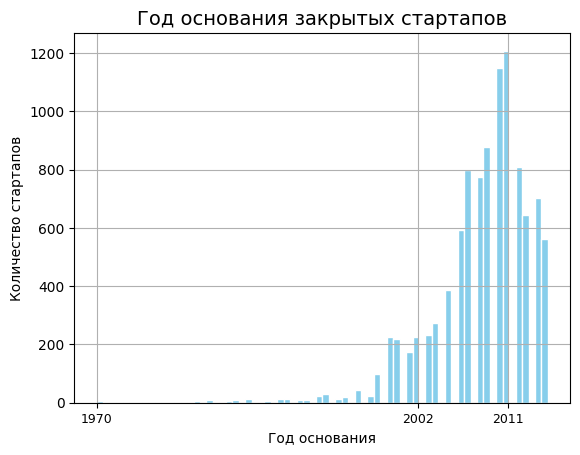

In [78]:
# Извлекаем год из даты основания
closed_df['foundation_year'] = closed_df['founded_at_date'].dt.year

# Строим гистограмму
closed_df['foundation_year'].hist(bins=70, color='skyblue')

plt.title('Год основания закрытых стартапов')
plt.xlabel('Год основания')
plt.xticks([1970, 2002, 2011,]) 
plt.ylabel('Количество стартапов')
plt.show()

В 2002 году произошел быстрый рост числа основания стартапов, в 2011 был достигнут пик и затем произошел резкий спад на треть от максимального числа.

Действующие стартапы.

In [79]:
# Найдём строку с самой ранней датой
idx_earliest = operating_df['founded_at_date'].idxmin()

# Найодём строку с самой поздней датой
idx_latest = operating_df['founded_at_date'].idxmax()

# Выводим строки с самой ранней и самой поздней датами
print("Строка с самой ранней датой основания:")
print(operating_df.loc[idx_earliest])

print("\nСтрока с самой поздней датой основания:")
print(operating_df.loc[idx_latest])

Строка с самой ранней датой основания:
name                     Worldwide Facilities
category_list                         Brokers
funding_total_usd                           0
status                              operating
country_code                              USA
state_code                                 CA
region                            Los Angeles
city                              Los Angeles
funding_rounds                              1
founded_at_date           1970-01-01 00:00:00
first_funding_at_date     2015-07-06 00:00:00
last_funding_at_date      2015-07-06 00:00:00
closed_at_date            2018-01-01 00:00:00
Name: 11611, dtype: object

Строка с самой поздней датой основания:
name                           KleenResource
category_list                  Biotechnology
funding_total_usd                          0
status                             operating
country_code                             USA
state_code                                NC
region                   

Самым ранним стартапом был Worldwide Facilities в Лос-Анджелесе, открыт был в 1970 году и действовал на момент выгрузки данных. Самым последним был открыт KleenResource в 2015 году.

Построим гистограмму по годам основания действующих стартапов.

/var/folders/g4/3vg7s0hj61z1d8hwbk8s10rh0000gn/T/ipykernel_23151/120080252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  operating_df['foundation_year'] = operating_df['founded_at_date'].dt.year


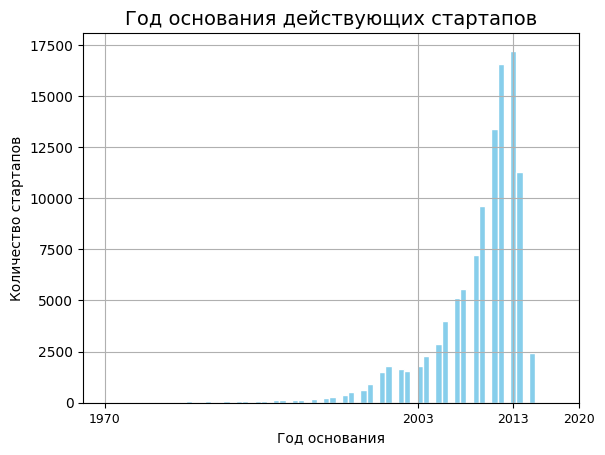

In [80]:
# Извлекаем год из даты основания
operating_df['foundation_year'] = operating_df['founded_at_date'].dt.year

# Строим гистограмму
operating_df['foundation_year'].hist(bins=70, color='skyblue')

plt.title('Год основания действующих стартапов')
plt.xlabel('Год основания')
plt.xticks([1970, 2003, 2013, 2020]) 
plt.ylabel('Количество стартапов')
plt.show()

В 2003 начался быстрый рост числа основания стартапов, в 2013 был достигнут пик и затем произошел резкий спад к 2018 году.

Обе группы характеризуются в начале 2000-х быстрым ростом числа основания стартапов, в 2011-2013 был достигнут пик и затем произошел резкий спад.

4.2 Финансирование стартапов.

Количественный признак.

Закрытые стартапы.

In [81]:
# Найдём строку с самой ранней датой
idx_min = closed_df['funding_total_usd'].idxmin()

# Найодём строку с самой поздней датой
idx_max = closed_df['funding_total_usd'].idxmax()

# Выводим строки с самой ранней и самой поздней датами
print("Строка с минимальным финансированием:")
print(closed_df.loc[idx_min])

print("\nСтрока с максимальным финансированием:")
print(closed_df.loc[idx_max])

Строка с минимальным финансированием:
name                                 WhipCar
category_list                     Automotive
funding_total_usd                          0
status                                closed
country_code                             GBR
state_code                                H9
region                                London
city                                  London
funding_rounds                             1
founded_at_date          2009-01-01 00:00:00
first_funding_at_date    2009-01-01 00:00:00
last_funding_at_date     2009-01-01 00:00:00
closed_at_date           2010-03-05 00:00:00
foundation_year                         2009
Name: 212, dtype: object

Строка с максимальным финансированием:
name                                Solyndra
category_list                  Manufacturing
funding_total_usd                 1567504319
status                                closed
country_code                             USA
state_code                                

Минимальное финансирование было у закрытого стартапа Salesjob - 0 долларов,  максимальное финансирование было у SoftViaNet - 1,57 млд. долларов.

Построим гистограмму и ящик с усами для данных финансирования закрытых стартапов.

In [82]:
closed_df['funding_total_usd'].describe()

count        10208
mean       7618869
std       36909920
min              0
25%          50000
50%         500000
75%        3500000
max     1567504319
Name: funding_total_usd, dtype: float64

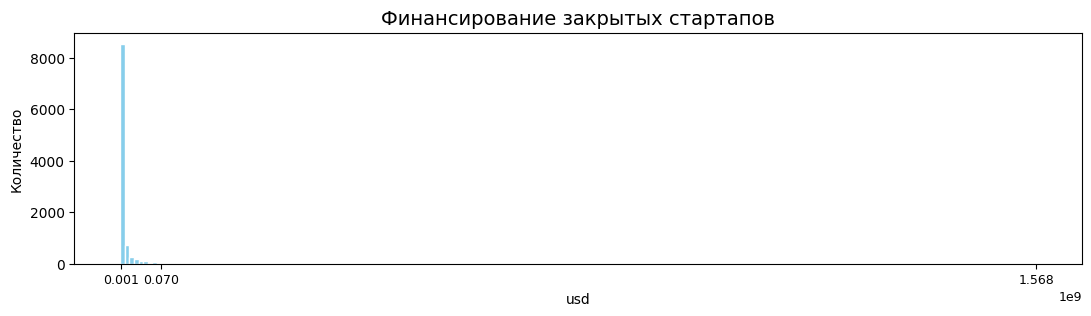

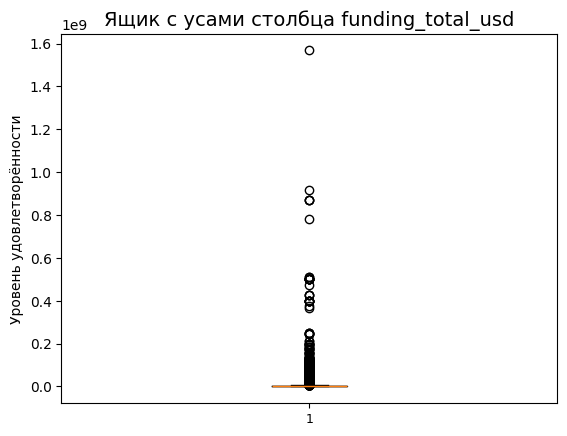

In [83]:
# Гистограмма
# Построение гистограмм
plt.figure(figsize=(13, 3))
plt.hist(closed_df['funding_total_usd'], bins=200, color='skyblue')
plt.title('Финансирование закрытых стартапов')
plt.xlabel('usd')
plt.xticks([1000000, 70000000, 1567504319]) 
plt.ylabel('Количество')
plt.show()

# Ящик с усами
plt.boxplot(closed_df['funding_total_usd'])
plt.title('Ящик с усами столбца funding_total_usd')
plt.ylabel('Уровень удовлетворённости')
plt.show()

Виден ярко выраженный единичный выброс, хоть он и является органическим для данных, но все же будет мешать хорошему обучению модели. Удалим его.

In [84]:
closed_df = closed_df.loc[closed_df['funding_total_usd'] != 1567504319]

In [85]:
closed_df['funding_total_usd'].describe()

count       10207
mean      7466044
std      33526696
min             0
25%         50000
50%        500000
75%       3500000
max     915000000
Name: funding_total_usd, dtype: float64

Выброс с максимальным бюджетом удален. Построим гистограмму, улучшело ли это однородность данных.

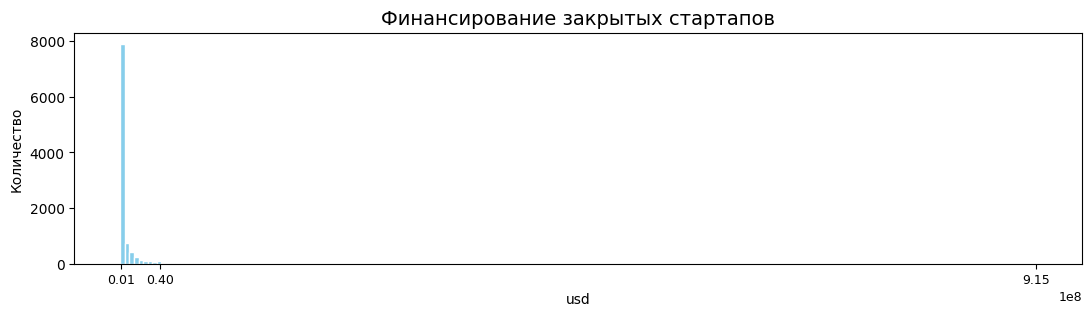

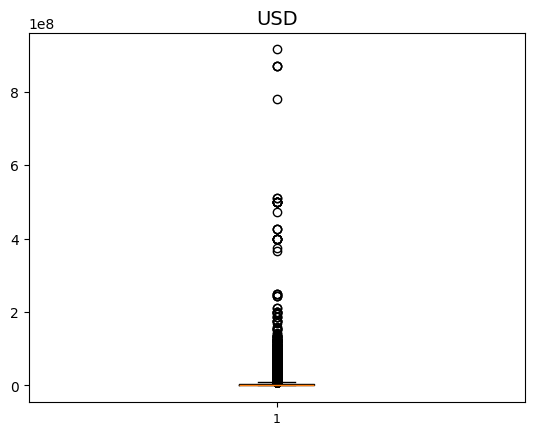

In [86]:
# Гистограмма
# Построение гистограмм
plt.figure(figsize=(13, 3))
plt.hist(closed_df['funding_total_usd'], bins=200, color='skyblue')
plt.title('Финансирование закрытых стартапов')
plt.xlabel('usd')
plt.xticks([1000000, 40000000, 915000000]) 
plt.ylabel('Количество')
plt.show()

# Ящик с усами
plt.boxplot(closed_df['funding_total_usd'])
plt.title('USD')
plt.show()

Выбросов по прежнему много, но они теперь не еденичны, в значит данные лучше отражают общую статистику.

Гистограмма показывает, что большенство стартапов получило финансирование от 1 (большенство) до 4 миллионов долларов, более 4 миллионов финансирование скорее редкость, чем распространенное явление.

Удалим строку с выбросом из тренировочной выборки.

Строка с выбросом успешно удалена.

Действующие стартапы.

In [87]:
operating_df['funding_total_usd'].describe()

count        110408
mean       15875404
std       201568448
min               0
25%           75000
50%         1000000
75%         6101427
max     30079503000
Name: funding_total_usd, dtype: float64

Минимальное финансирование было у закрытого стартапа - 0 долларов,  максимальное финансирование было - 30 млд. долларов.

Максимальное финансирование у действующих стартапов примерно в 30 раз выше.

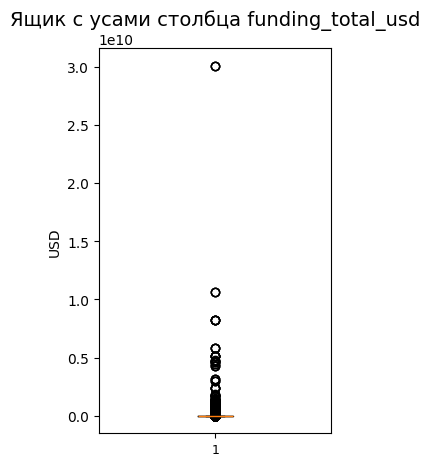

In [88]:
# Ящик с усами
plt.figure(figsize=(3, 5))
plt.boxplot(operating_df['funding_total_usd'])
plt.title('Ящик с усами столбца funding_total_usd')
plt.ylabel('USD')
plt.show()

In [89]:
operating_df = operating_df.loc[operating_df['funding_total_usd'] != 30079503000]
operating_df['funding_total_usd'].describe()

count        110405
mean       15058494
std       126770632
min               0
25%           75000
50%         1000000
75%         6100000
max     10664943639
Name: funding_total_usd, dtype: float64

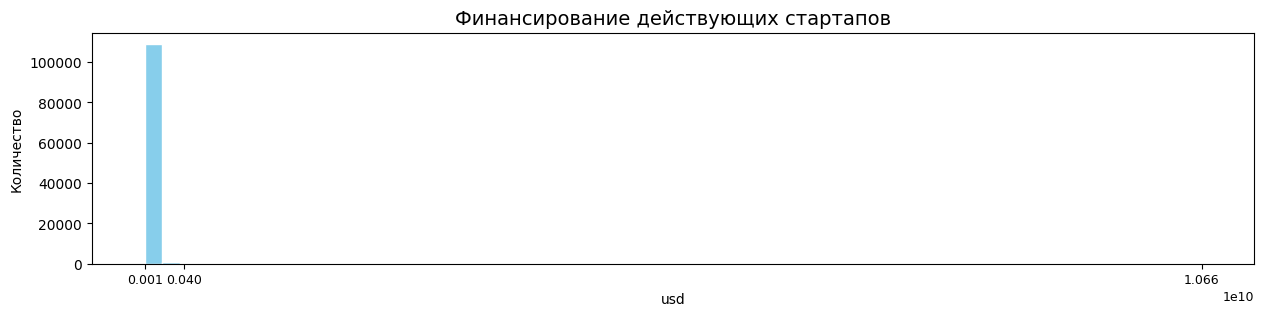

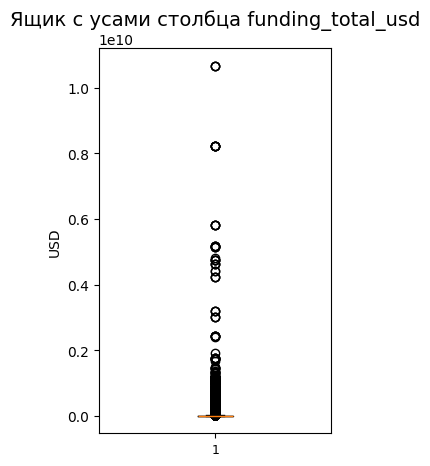

In [90]:
# Гистограмма
# Построение гистограмм
plt.figure(figsize=(15, 3))
plt.hist(operating_df['funding_total_usd'], bins=60, color='skyblue')
plt.title('Финансирование действующих стартапов')
plt.xlabel('usd')
plt.xticks([6000000, 400000000, 10664943639]) 
plt.ylabel('Количество')
plt.show()

# Ящик с усами
plt.figure(figsize=(3, 5))
plt.boxplot(operating_df['funding_total_usd'])
plt.title('Ящик с усами столбца funding_total_usd')
plt.ylabel('USD')
plt.show()

Единичный выброс удален. Есть много выбросов, но оставим их и подберем модель, которая с ними спавится.

Удалим из тренеровочной выборки строки с выбросами.

In [91]:
# Список значений для удаления
values_to_remove = [1567504319, 30079503000]

# Удаление строк, где 'funding_total_usd содержит любое из значений для удаления
train_filtered = train_filtered_date[~train_filtered_date['funding_total_usd'].isin(values_to_remove)]
train_filtered.shape

(120612, 13)

4.3 Сравнительный вывод по стартапам.

Совпадения:
- по категориям - Software, Mobile;
- по странам - США, неизвестная страна, Великобритания,  Канада;
- полное совпадение по штатам;
- полное совпадение по регионам;
- по городам - Сан-Франциско, Нью-Йорк, Лондон;
- по числу раундов - большенство прошло малое количество раундов;
- по году основания - быстрый рост в начале 2000-х;
- по финансированию - есть стартапы, которые его не получали. 

Отличия:
-  по категориям - категория не указана, Curated Web,  Social Media;
- по странам - Россия и Индия;
- по городам - Лос-Анджелес и Поло-Альто;
- по числу раундов - действующие стартапы прошли больше раундов по сравнению с закрытыми;
- по году основания - резкое падение у действующих произошло на два года позже;
- по финансированию - максимальный бюджет финансирования у действующих стартапов примерно в 30 раз выше.

### 5.  Новые синтетические признаки

days_first, новый признак, который будет отражать количество дней с момента основания до первого раунда финансирования.

In [92]:
# Вычисление разницы в днях
train_filtered.dropna(subset=['first_funding_at_date', 'founded_at_date'], inplace=True)
train_filtered['days_first'] = (train_filtered['first_funding_at_date'] - train_filtered['founded_at_date']).dt.days
train_filtered['days_first'].describe()

/var/folders/g4/3vg7s0hj61z1d8hwbk8s10rh0000gn/T/ipykernel_23151/3964310389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered.dropna(subset=['first_funding_at_date', 'founded_at_date'], inplace=True)
/var/folders/g4/3vg7s0hj61z1d8hwbk8s10rh0000gn/T/ipykernel_23151/3964310389.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered['days_first'] = (train_filtered['first_funding_at_date'] - train_filtered['founded_at_date']).dt.days


count   120545
mean       818
std       1463
min      -9465
25%        147
50%        412
75%        820
max      16708
Name: days_first, dtype: float64

In [93]:
train_filtered.columns

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at_date',
       'first_funding_at_date', 'last_funding_at_date', 'closed_at_date',
       'days_first'],
      dtype='object')

In [94]:
# Фильтр для нахождения строк, содержащих хотя бы одно отрицательное значение
mask = train_filtered['days_first'] < 0

# Вывод строк, удовлетворяющих нашему условию
negative_values_rows = train_filtered[mask]

negative_values_rows.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at_date,first_funding_at_date,last_funding_at_date,closed_at_date,days_first
62,Evargrah Entertainment Group,Entertainment,0,operating,USA,CA,Los Angeles,Los Angeles,1,2013-08-13,2013-07-09,2013-07-09,2018-01-01,-35
63,Evargrah Entertainment Group,Games,0,operating,USA,CA,Los Angeles,Los Angeles,1,2013-08-13,2013-07-09,2013-07-09,2018-01-01,-35
159,Box Upon a Time,Fashion,389454,operating,unknown,unknown,unknown,unknown,2,2014-04-01,2013-12-09,2014-09-09,2018-01-01,-113


In [95]:
# Удаление строк, где значения в столбце days_first отрицательные
train_filtered = train_filtered[train_filtered['days_first'] > 0]
train_filtered['days_first'].describe()

count   104247
mean       970
std       1510
min          1
25%        255
50%        494
75%        964
max      16708
Name: days_first, dtype: float64

days_last - новый признак, который будет отражать количество дней с момента основания до первого раунда финансирования.

In [96]:
# Вычисление разницы в днях
train_filtered['days_last'] = (train_filtered['last_funding_at_date'] - train_filtered['first_funding_at_date']).dt.days
train_filtered['days_last'].describe()

count   104247
mean       357
std        724
min          0
25%          0
50%          0
75%        470
max      36994
Name: days_last, dtype: float64

days, новый признак, который будет отражать количество лет с момента основания до выгрузки или закрытия стартапа.

In [97]:
# Вычисление разницы в днях
train_filtered['days'] = (train_filtered['closed_at_date'] - train_filtered['founded_at_date']).dt.days
train_filtered['days'].describe()

count   104247
mean      3042
std       2023
min        381
25%       1779
50%       2443
75%       3653
max      34089
Name: days, dtype: float64

In [98]:
train_filtered.sample(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at_date,first_funding_at_date,last_funding_at_date,closed_at_date,days_first,days_last,days
71750,PenPath,Publishing,50000,operating,USA,MO,St. Louis,St Louis,1,2013-02-16,2014-01-01,2014-01-01,2018-01-01,319,0,1780
43411,datapath.io,Internet Infrastructure,118000,operating,DEU,5,Frankfurt,Frankfurt,1,2015-01-01,2015-06-15,2015-06-15,2018-01-01,165,0,1096
112989,Pipefy,Software,200000,operating,USA,DE,"Wilmington, Delaware",Wilmington,1,2014-01-15,2015-07-23,2015-07-23,2018-01-01,554,0,1447


In [99]:
train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104247 entries, 0 to 120615
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   name                   104247 non-null  object        
 1   category_list          104247 non-null  object        
 2   funding_total_usd      104247 non-null  int64         
 3   status                 104247 non-null  object        
 4   country_code           104247 non-null  object        
 5   state_code             104247 non-null  object        
 6   region                 104247 non-null  object        
 7   city                   104247 non-null  object        
 8   funding_rounds         104247 non-null  int64         
 9   founded_at_date        104247 non-null  datetime64[ns]
 10  first_funding_at_date  104247 non-null  datetime64[ns]
 11  last_funding_at_date   104247 non-null  datetime64[ns]
 12  closed_at_date         104247 non-null  datetime6

foundation_year - новый признак, показывающий год основания.

In [100]:
# Создаем новый столбец 'foundation_year', извлекая год из 'date_of_foundation'
train_filtered['foundation_year'] = train_filtered['founded_at_date'].dt.year
train_filtered.columns

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at_date',
       'first_funding_at_date', 'last_funding_at_date', 'closed_at_date',
       'days_first', 'days_last', 'days', 'foundation_year'],
      dtype='object')

rank_funding_total - расчет ранга финансирования в каждом городе.

In [101]:
# Расчет ранга финансирования в каждом городе
train_filtered['rank_funding_total'] = train_filtered.groupby('city')['funding_total_usd'].rank()
train_filtered.columns

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at_date',
       'first_funding_at_date', 'last_funding_at_date', 'closed_at_date',
       'days_first', 'days_last', 'days', 'foundation_year',
       'rank_funding_total'],
      dtype='object')

fin_category - разбиение финансирования на категории, разбив объем финансирования на диапазоны (бины), например, "низкий", "средний", "высокий".

In [102]:
train_filtered['funding_total_usd'].describe()

count        104247
mean       15096287
std       125250350
min               0
25%           95000
50%         1030000
75%         6871624
max     10664943639
Name: funding_total_usd, dtype: float64

In [103]:
train_filtered['fin_category'] = pd.cut(train_filtered['funding_total_usd'], bins=[0, 50000, 7000000, 11000000000], labels=["низкий", "средний", "высокий"])
train_filtered.columns

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at_date',
       'first_funding_at_date', 'last_funding_at_date', 'closed_at_date',
       'days_first', 'days_last', 'days', 'foundation_year',
       'rank_funding_total', 'fin_category'],
      dtype='object')

In [104]:
train_filtered['fin_category'] = train_filtered['fin_category'].astype(str)  

### 6.  Проверка на мультиколлинеарность входящих признаков

In [105]:
# Исправленное удаление столбцов
#train_filtered = train_filtered.drop(['name', 'founded_at_date', 'first_funding_at_date', 
#                                      'last_funding_at_date', 'closed_at_date'], axis=1)

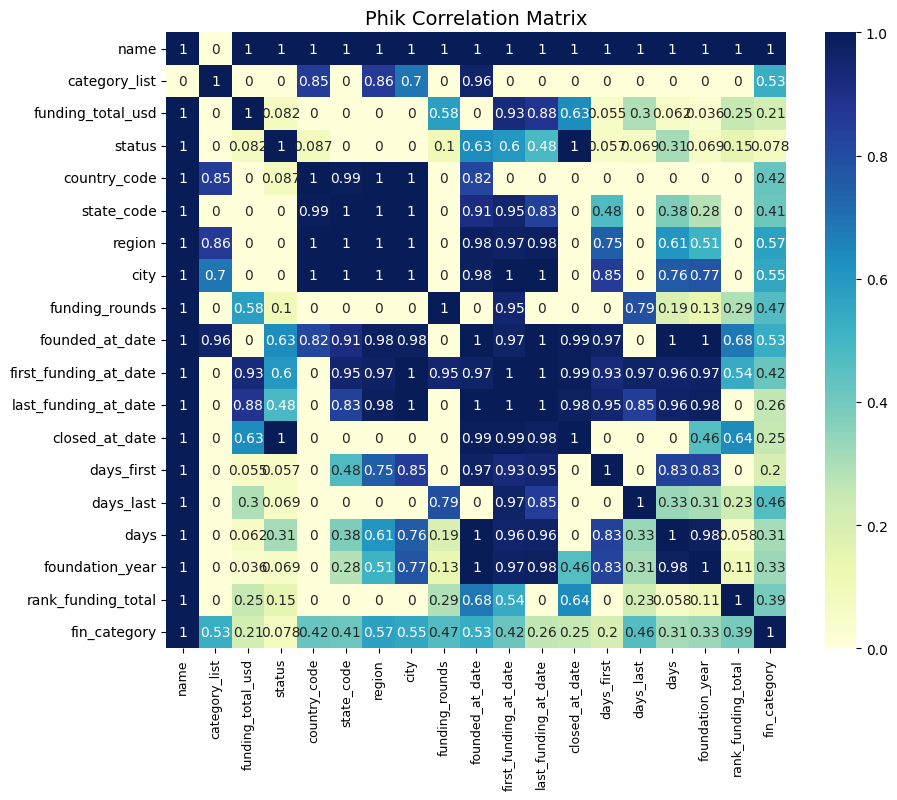

In [106]:

# Вычисляем матрицу корреляции phik
phik_overview = train_filtered.sample(1000).phik_matrix(interval_cols=['funding_total_usd', 'funding_rounds', 
                                                                       'days_first', 'days_last', 'days',
                                                                       'foundation_year', 'rank_funding_total'])
# 
plt.figure(figsize=(10, 8))
sns.heatmap(phik_overview, annot=True, cmap="YlGnBu")
plt.title('Phik Correlation Matrix')
plt.show()

Высокая мультиколлинеарность целевого признака наблюдается по отношению к признаку даты основания, даты последнего раунда и общего количества дней существования стартапа на момент выгрузки.

### 7.  Отбор финального набора обучающих признаков

Удалим из выборки столбец name, проверим на дубликаты и удалим их если появятся.

In [107]:
# Исправленное удаление столбцов
train = train_filtered.drop(['name'], axis=1)
# Проверим дубликаты и выведем их сумму
train.duplicated().sum()

17

In [108]:
train = train.drop_duplicates()
train.duplicated().sum()

0

Дубликаты устранены.

In [109]:
train.columns

Index(['category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at_date',
       'first_funding_at_date', 'last_funding_at_date', 'closed_at_date',
       'days_first', 'days_last', 'days', 'foundation_year',
       'rank_funding_total', 'fin_category'],
      dtype='object')

В тренировочную выборку не войдут следующие признаки 'category_list', 'state_code', 'region', 'founded_at_date', 'first_funding_at_date', 'last_funding_at_date', 'closed_at_date'.

### 8.  Выбор и обучение моделей

In [110]:
# Создаем тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(
    train.drop(['status', 'category_list', 'state_code', 'region',
                           'founded_at_date', 'first_funding_at_date', 'last_funding_at_date',
                           'closed_at_date'], axis=1),
    train['status'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = train['status'])

Обучим четыре модели: 
- KNeighborsClassifier(), 
- DecisionTreeClassifier(), 
- LogisticRegression(),
- SVC().

Для каждой из них подберем как минимум один гиперпараметр. Подходящей для задачи метрикой будет roc_auc, поскольку она часто используется в задачах бинарной классификации, и она предоставляет информацию о качестве модели, учитывая как чувствительность (True Positive Rate), так и специфичность (True Negative Rate).

In [111]:
X_train.shape

(78172, 10)

In [112]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78172 entries, 115414 to 46596
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   funding_total_usd   78172 non-null  int64  
 1   country_code        78172 non-null  object 
 2   city                78172 non-null  object 
 3   funding_rounds      78172 non-null  int64  
 4   days_first          78172 non-null  int64  
 5   days_last           78172 non-null  int64  
 6   days                78172 non-null  int64  
 7   foundation_year     78172 non-null  int32  
 8   rank_funding_total  78172 non-null  float64
 9   fin_category        78172 non-null  object 
dtypes: float64(1), int32(1), int64(5), object(3)
memory usage: 6.3+ MB


In [113]:
# списки с названиями признаков
ord_columns = ['country_code', 'city', 'fin_category',]
num_columns = ['funding_total_usd', 'funding_rounds', 'days_first', 'days_last', 'days', 'foundation_year', 
               'rank_funding_total']
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
#ohe_pipe = Pipeline(
#    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
#     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
#    ]
#    )
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
    #('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)
param_grid = [
    # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(2, 5),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), RobustScaler()]   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 8),
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']  
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ])
grid_search = GridSearchCV(
    pipe_final, 
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Выполнение предсказаний на тестовом наборе данных
y_pred = grid_search.predict(X_test)

# Теперь используем y_test (истинные значения) и y_pred (предсказанные значения)
# Если 'operating' считается классом "1" (положительным)
f1_o = f1_score(y_test, y_pred, average='macro', pos_label='operating')


print('F1-score: operating', f1_o)


print('\nЛучшая модель и её параметры:\n\n', grid_search.best_estimator_) 

/Users/irina/GitHub/project-startups/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/irina/GitHub/project-startups/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/irina/GitHub/project-startups/myenv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/irina/GitHub/project-startups/myenv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
     

F1-score: operating 0.9247755555854816

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['country_code', 'city',

/Users/irina/GitHub/project-startups/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1561: UserWarning: Note that pos_label (set to 'operating') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Благодаря использованию пайплайна и инструмента подбора гиперпараметров для каждой модели отдельно, выявлена лучшая модель - KNeighborsClassifier(n_neighbors=2). Метрика F1-score для этой модели: 0.92.

Предсказания на тестовой выборке.

In [114]:
best_model = grid_search.best_estimator_

# Предсказание на тестовой выборке
predictions_log = best_model.predict(X_test)

# Расчет метрик
accuracy = accuracy_score(y_test, predictions_log)
recall = recall_score(y_test, predictions_log, pos_label='closed')
precision = precision_score(y_test, predictions_log, pos_label='closed')

# Вывод метрик
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, predictions_log)
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.9780105917568501
Recall: 0.8701171875
Precision: 0.8530397319291527
Confusion Matrix:
[[ 1782   266]
 [  307 23703]]


### 9.  Анализ важности ее признаков

In [115]:
param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(2, 5),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]
    

In [116]:
X_train.shape

(78172, 10)

In [117]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

/Users/irina/GitHub/project-startups/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/irina/GitHub/project-startups/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=nan)),
                                                                                               ('simpleImputer_after_ord',
                                                                                                SimpleImputer(strategy='most_frequent...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [DecisionTreeClassifier(random_state=42)],
                                         'models__max_depth': range(2, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

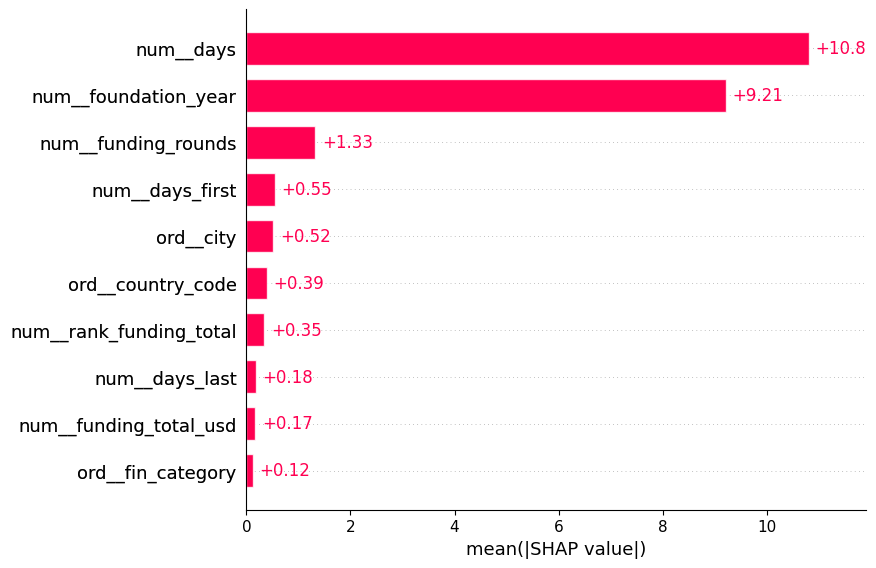

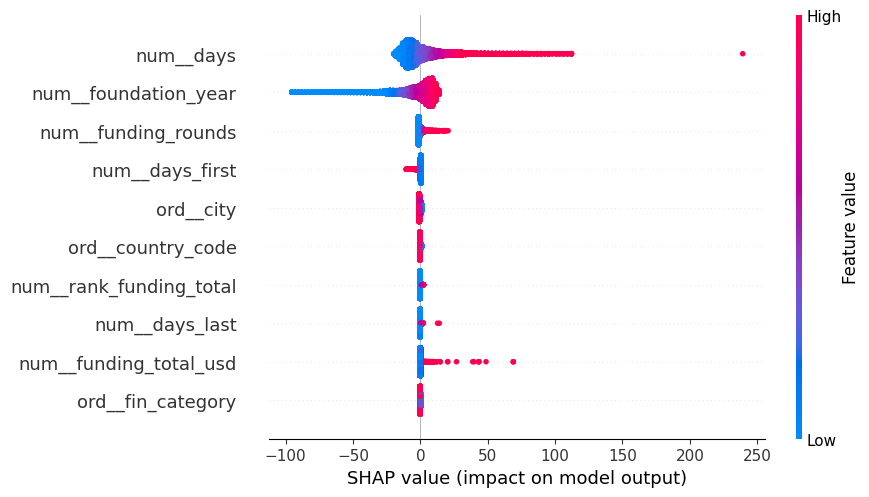

In [118]:
X_train_best = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_best = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test_best = pd.DataFrame(X_test_best, columns=feature_names)

# Создание объекта Explainer для модели 
explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], X_train_best) 
shap_values = explainer(X_test_best)

# График важности признаков обученной модели логистической регрессии.  
shap.plots.bar(shap_values, max_display=22)
shap.plots.beeswarm(shap_values, max_display=22) 


Максимальное влияние оказали признаки days, foundation_year, funding_rounds.

### 10. Предсказания

Создадим аналогичные признаки для новой выборки.

In [119]:
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13211 entries, 0 to 13210
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13211 non-null  object 
 1   category_list      13211 non-null  object 
 2   funding_total_usd  10616 non-null  float64
 3   country_code       11827 non-null  object 
 4   state_code         11512 non-null  object 
 5   region             11618 non-null  object 
 6   city               11620 non-null  object 
 7   funding_rounds     13211 non-null  int64  
 8   founded_at         13211 non-null  object 
 9   first_funding_at   13211 non-null  object 
 10  last_funding_at    13211 non-null  object 
 11  closed_at          1234 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 1.2+ MB


In [120]:
# Проверка количества пропусков
startups_test.isna().sum()

name                     0
category_list            0
funding_total_usd     2595
country_code          1384
state_code            1699
region                1593
city                  1591
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            11977
dtype: int64

In [121]:
startups_test['funding_total_usd'].fillna(0.0, inplace=True)
# Преобразование столбца funding_total_usd из float в int64
startups_test['funding_total_usd'] = startups_test['funding_total_usd'].astype('int64')
startups_test.isna().sum()

/var/folders/g4/3vg7s0hj61z1d8hwbk8s10rh0000gn/T/ipykernel_23151/2240175596.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  startups_test['funding_total_usd'].fillna(0.0, inplace=True)


name                     0
category_list            0
funding_total_usd        0
country_code          1384
state_code            1699
region                1593
city                  1591
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            11977
dtype: int64

In [122]:
columns_to_replace = ['country_code', 'state_code', 'region', 'city']  # Список столбцов для замены

# Замена значений NaN на 'unknown' в указанных столбцах
startups_test[columns_to_replace] = startups_test[columns_to_replace].fillna('unknown')
startups_test.isna().sum()

name                     0
category_list            0
funding_total_usd        0
country_code             0
state_code               0
region                   0
city                     0
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            11977
dtype: int64

In [123]:
startups_test.columns

Index(['name', 'category_list', 'funding_total_usd', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'closed_at'],
      dtype='object')

'founded_at_date',
       'first_funding_at_date', 'last_funding_at_date', 'closed_at_date'

In [124]:
# Преобразование столбца founded_at с датами из строки в datetime
startups_test['founded_at_date'] = pd.to_datetime(startups_test['founded_at'])
startups_test['first_funding_at_date'] = pd.to_datetime(startups_test['first_funding_at'])
startups_test['last_funding_at_date'] = pd.to_datetime(startups_test['last_funding_at'])
startups_test['last_funding_at_date'] = pd.to_datetime(startups_test['last_funding_at'])

# Преобразуем столбец
startups_test['closed_at_date'] = pd.to_datetime(startups_test['closed_at'])
# Заполняем пропуски
startups_test['closed_at_date'].fillna(pd.Timestamp('2018-01-01'), inplace=True)
# Удалим столбец closed_at
del startups_test['closed_at']

# Удалим столбец founded_at
del startups_test['founded_at']
del startups_test['first_funding_at']
del startups_test['last_funding_at']
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13211 entries, 0 to 13210
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   13211 non-null  object        
 1   category_list          13211 non-null  object        
 2   funding_total_usd      13211 non-null  int64         
 3   country_code           13211 non-null  object        
 4   state_code             13211 non-null  object        
 5   region                 13211 non-null  object        
 6   city                   13211 non-null  object        
 7   funding_rounds         13211 non-null  int64         
 8   founded_at_date        13211 non-null  datetime64[ns]
 9   first_funding_at_date  13211 non-null  datetime64[ns]
 10  last_funding_at_date   13211 non-null  datetime64[ns]
 11  closed_at_date         13211 non-null  datetime64[ns]
dtypes: datetime64[ns](4), int64(2), object(6)
memory usage: 1.2+

/var/folders/g4/3vg7s0hj61z1d8hwbk8s10rh0000gn/T/ipykernel_23151/1311353973.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  startups_test['closed_at_date'].fillna(pd.Timestamp('2018-01-01'), inplace=True)


'days_first', 'days_last', 'days',

In [125]:
# Вычисление разницы в днях
startups_test.dropna(subset=['first_funding_at_date', 'founded_at_date'], inplace=True)
startups_test['days_first'] = (startups_test['first_funding_at_date'] - startups_test['founded_at_date']).dt.days
startups_test['days_last'] = (startups_test['last_funding_at_date'] - startups_test['first_funding_at_date']).dt.days
startups_test['days'] = (startups_test['closed_at_date'] - startups_test['founded_at_date']).dt.days
startups_test.columns

Index(['name', 'category_list', 'funding_total_usd', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at_date',
       'first_funding_at_date', 'last_funding_at_date', 'closed_at_date',
       'days_first', 'days_last', 'days'],
      dtype='object')

'foundation_year'

In [126]:
# Создаем новый столбец 'foundation_year', извлекая год из 'date_of_foundation'
startups_test['foundation_year'] = startups_test['founded_at_date'].dt.year
startups_test.columns

Index(['name', 'category_list', 'funding_total_usd', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at_date',
       'first_funding_at_date', 'last_funding_at_date', 'closed_at_date',
       'days_first', 'days_last', 'days', 'foundation_year'],
      dtype='object')

'rank_funding_total',

In [127]:
# Расчет ранга финансирования в каждом городе
startups_test['rank_funding_total'] = startups_test.groupby('city')['funding_total_usd'].rank()
startups_test.columns

Index(['name', 'category_list', 'funding_total_usd', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at_date',
       'first_funding_at_date', 'last_funding_at_date', 'closed_at_date',
       'days_first', 'days_last', 'days', 'foundation_year',
       'rank_funding_total'],
      dtype='object')

'fin_category'

In [128]:
startups_test['fin_category'] = pd.cut(startups_test['funding_total_usd'], bins=[0, 50000, 7000000, 11000000000], labels=["низкий", "средний", "высокий"])
train_filtered['fin_category'] = train_filtered['fin_category'].astype(str)  
startups_test.columns

Index(['name', 'category_list', 'funding_total_usd', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at_date',
       'first_funding_at_date', 'last_funding_at_date', 'closed_at_date',
       'days_first', 'days_last', 'days', 'foundation_year',
       'rank_funding_total', 'fin_category'],
      dtype='object')

Сделаем предсказания.

In [129]:
# Предположим, что best_model — это ваша лучшая модель
y_new_pred = best_model.predict(startups_test)

# Создание DataFrame с предсказаниями
predictions_df = pd.DataFrame(y_new_pred, columns=['Predicted_Label'])

# Если вам нужно включить исходные данные из X_new в DataFrame
# Убедитесь, что X_new преобразован в DataFrame, если он еще не в этом формате
X_new_df = pd.DataFrame(startups_test)

# Допустим, что X_new_df уже содержит имена столбцов
# Объединяем исходные данные и предсказания
result_df = pd.concat([X_new_df, predictions_df], axis=1)

# Переименование 'Predicted_Label' в status
result_df.rename(columns={'Predicted_Label': 'status'}, inplace=True)

# удаление столбцов
result = result_df.loc[:, ['name', 'status']]

# Сохранение DataFrame в CSV-файл
result.to_csv('predictions_6.csv', index=False)
result.columns

Index(['name', 'status'], dtype='object')

### 11. Вывод по проекту 

Работа над проектом происходидила в рамках соревнования на платформе Kaggle, c псевдо-реальными данными о стартапах. Было предсказано, какие из них закроются, а какие нет.

*Основные проделаные этапы:*
 - загрузка и ознакомление с данными, 
 - предварительная обработка,
 - полноценный разведочный анализ,
 - разработка новых синтетических признаков,
 - проверка на мультиколлинеарность,
 - отбор финального набора обучающих признаков,
 - выбор и обучение моделей,
 - итоговая оценка качества предсказания лучшей модели,
 - анализ важности ее признаков,
 - формирование итогов исследования.
  
*Реализовано дополнительное задание:*

- реализовано решение с использованием технологии pipeline (из библиотеки sklearn);
- выполнен полноценный исследовательский анализ - выделить важные компоненты из данных, влияющие на работу стартапов. Сформулировать рекомендации позволяющие повысить шанс на успех стартапа;
- подготовлен отчет по исследованию (в процессе вёрстки).

*Данные.*

Датасет состоит из двух файлов: 
- тренировочный набор __kaggle_startups_train_01.csv__;
- тестовый набор __kaggle_startups_test_01.csv__ .
  
Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

*Описание полей данных:*
- __name__ - название стартапа,
- __category_list__ - cписок категорий, к которым относится стартап,
- __funding_total_usd__- общая сумма финансирования в USD,
- __status__ - статус стартапа (закрыт или действующий),
- __country_code__ - код страны,
- __state_code__ - код штата,
- __region__ - регион,
- __city__ - город,
- __funding_rounds__ - количество раундов финансирования,
- __founded_at__ - дата основания,
- __first_funding_at__ - дата первого раунда финансирования,
- __last_funding_at__ - дата последнего раунда финансирования,
- __closed_at__ - дата закрытия стартапа (если применимо).

В результате работы с тренировочными и тестовыми данными при помощи машинного обучения сформировался ряд рекомендаций по улучшению сбора данных заказком, с целью повышения качества предсказания модели:
- укрупнить категории стартапов, так как на данный момент слишком много единичных или очень редко встречающихся категорий, можно ограничиться лишь отраслью в которой работает стартап;
- оставить данные только о стране и городе;
- добавить данные о налоговых особеностях штатов и регионов;
- более тщательно собирать данные о стране и городе;
- добавить данные о сумме финансирования в каждом раунде;
- добавить данные о количестве сотрудников в стртапе.
  
Все эти рекомендации сделают процесс предсказания более эфективным, что позволит сократить риски, при не точном предсказании вероятности закрытия стартапа.